In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas
import pandas as pd
import os.path as p
%matplotlib inline

In [2]:
datasource_path = "UrbanSound8k"
audio_source = p.join(datasource_path, "audio")
metadata_path = p.join(p.join(datasource_path, "metadata"),"UrbanSound8k.csv")
metadata = pd.read_csv(metadata_path, index_col="fsID")
spectro_path = p.join("UrbanSound8k", "spectrogram")
folds = ["fold{}".format(str(i)) for i in range(1,11)]

metadata[:5]

,slice_file_name,start,end,salience,fold,classID,class
fsID,,,,,,,
100032,100032-3-0-0.wav,0.0,0.317551,1,5,3,dog_bark
100263,100263-2-0-117.wav,58.5,62.500000,1,5,2,children_playing
100263,100263-2-0-121.wav,60.5,64.500000,1,5,2,children_playing
100263,100263-2-0-126.wav,63.0,67.000000,1,5,2,children_playing
100263,100263-2-0-137.wav,68.5,72.500000,1,5,2,children_playing


In [3]:
def create_folders():
    to_create =[spectro_path]+ [p.join(spectro_path, fold) for fold in folds]
    
    for dirName in to_create:
        try:
            # Create target Directory
            os.mkdir(dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")

create_folders()

Directory  UrbanSound8k\spectrogram  already exists
Directory  UrbanSound8k\spectrogram\fold1  already exists
Directory  UrbanSound8k\spectrogram\fold2  already exists
Directory  UrbanSound8k\spectrogram\fold3  already exists
Directory  UrbanSound8k\spectrogram\fold4  already exists
Directory  UrbanSound8k\spectrogram\fold5  already exists
Directory  UrbanSound8k\spectrogram\fold6  already exists
Directory  UrbanSound8k\spectrogram\fold7  already exists
Directory  UrbanSound8k\spectrogram\fold8  already exists
Directory  UrbanSound8k\spectrogram\fold9  already exists
Directory  UrbanSound8k\spectrogram\fold10  already exists


In [4]:
def plot_spectrogram(filename):
    plt.interactive(False)
    filename, _ = build_path(filename)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig, ax = plt.subplots()
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()

    
def create_spectrogram(filename):
    plt.interactive(False)
    filename, fold_id =build_path(filename)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    curr_path = p.join(spectro_path, folds[fold_id])
    savefile  = p.join(curr_path, "{}.jpg".format(p.basename(filename).split(".")[0] ))
    plt.savefig(savefile, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,clip,sample_rate,fig,ax,S,savefile
    
def build_path(file_name, spectrogram = False):
    file=file_name.split(".")
    source = spectro_path if spectrogram else audio_source
    file_name = file[0] + ".jpg" if spectrogram else file[0] +".wav"
    fsID= int(file_name.split("-")[0])
    frame = metadata.loc[fsID]
    fold_id = 0
    try:
        fold_id = frame["fold"].values[0]-1
    except:
        fold_id = frame["fold"] -1
    file_with_fold = p.join(folds[fold_id], file_name)
    return p.join(source,file_with_fold), fold_id

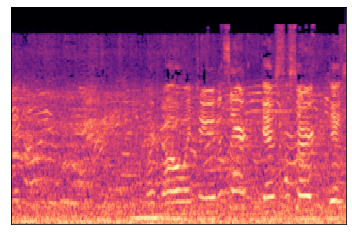

In [6]:
create_spectrogram("100263-2-0-126..wav")
plot_spectrogram("100263-2-0-126..wav")

In [ ]:
from tqdm import tqdm_notebook

import gc
counter = 0
errors =0
for index, row in tqdm_notebook(metadata.iterrows()):
    counter += 1
    if counter%2000 ==0:
        gc.collect()
    try:
        file_name = row["slice_file_name"]
        s,_ = build_path(file_name, True)
        metadata.loc[index, "spectro_path"] = s
        if not p.exists(s): create_spectrogram(file_name)
    except Exception as e:
        errors +=1

print(counter)
print(errors)
print(counter - errors)
metadata[:5]

In [282]:
from tensorflow.python.keras import layers, models
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold


In [256]:
def get_fold(idx):
    return metadata[metadata.fold == index]

def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [286]:
datagen=ImageDataGenerator(rescale=1./255)
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

X_train = metadata["spectro_path"]
y_train = metadata["class"]
skf = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X_train, y_train))

In [290]:
for j, (train_idx, val_idx) in enumerate(skf):
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = datagen.flow_from_dataframe(X_train_cv, y_train_cv, batch_size = 32)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0


AttributeError: 'ImageDataGenerator' object has no attribute 'flow_from_dataframe'